In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import color, data, restoration
from scipy.signal import convolve2d
from skimage.util import random_noise

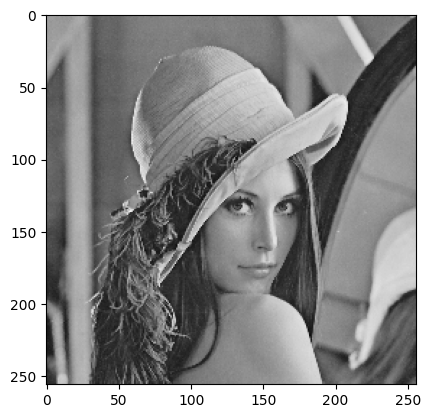

In [2]:
img = cv2.imread(r"D:/Malathi/SEM_6/IVP/lena256.png") 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgplot = plt.imshow(img, cmap='grey')
plt.show()

## WIENER FILTER case 1

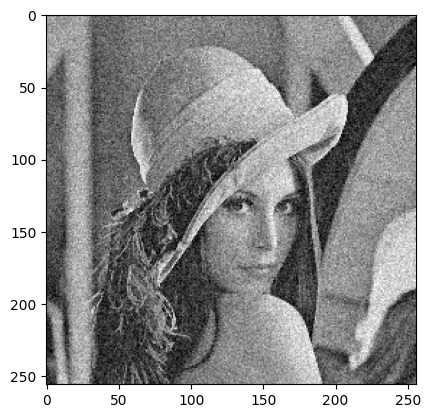

In [3]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img
noisy = add_gaussian_noise(img, 20)
#noisy = random_noise(Af, mode = 'gaussian', mean = 0, var = 0.0001)
plt.imshow(noisy, cmap='grey')

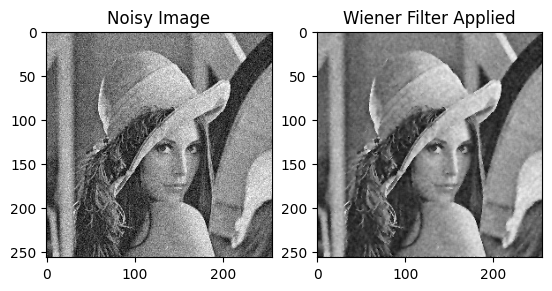

In [4]:
from scipy.signal import wiener

filtered_img = wiener(noisy, (3, 3))  
f, (plot1, plot2) = plt.subplots(1, 2)

plot1.imshow(noisy, cmap='gray')
plot1.set_title("Noisy Image")

plot2.imshow(filtered_img, cmap='gray')
plot2.set_title("Wiener Filter Applied")

plt.show()

In [21]:
def calculate_psnr(original, noisy):
    original_image_float32 = original.astype(np.float32)
    noisy_image_float32 = noisy.astype(np.float32)
    mse = np.mean((original - noisy) ** 2)
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

psnr1 = calculate_psnr(img, noisy)
psnr2 = calculate_psnr(img, filtered_img)
print("PSNR for original and noisy image: ", psnr1)
print("PSNR for original image and wiener image: ", psnr2)

PSNR for original and noisy image:  22.13511363667957
PSNR for original image and wiener image:  27.8094522429542


## WIENER FILTER case 2

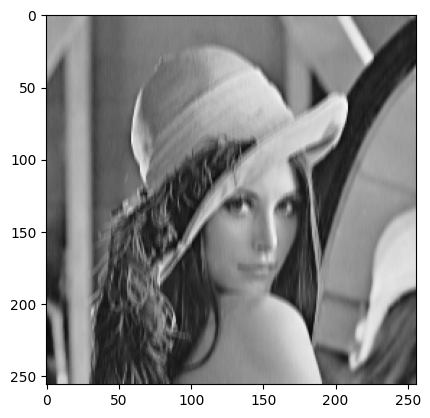

In [4]:
# Motion Blur
kernel_size = 5
  
# Create the vertical kernel. 
kernel_v = np.zeros((kernel_size, kernel_size)) 
  
# Fill the middle row with ones. 
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
  
# Normalize. 
kernel_v /= kernel_size 
  
# Apply the vertical kernel. 
vertical_mb = cv2.filter2D(img, -1, kernel_v) 

plt.imshow(vertical_mb, cmap='grey')

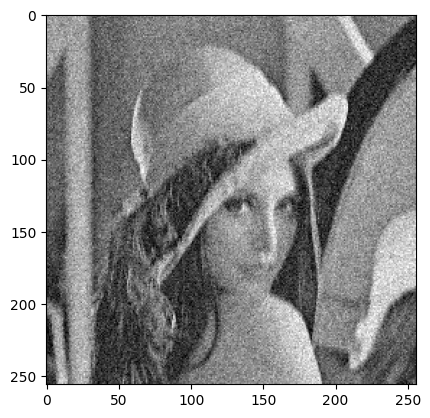

In [5]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img
motion_noisy = add_gaussian_noise(vertical_mb, 20)
#noisy = random_noise(Af, mode = 'gaussian', mean = 0, var = 0.0001)
plt.imshow(motion_noisy, cmap='grey')

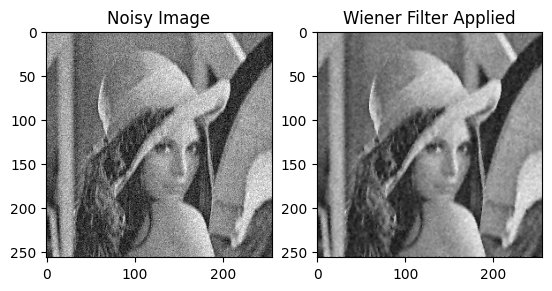

In [28]:
from scipy.signal import wiener

filtered_img2 = wiener(motion_noisy, (3, 3))  
f, (plot1, plot2) = plt.subplots(1, 2)

plot1.imshow(motion_noisy, cmap='gray')
plot1.set_title("Noisy Image")

plot2.imshow(filtered_img2, cmap='gray')
plot2.set_title("Wiener Filter Applied")

plt.show()

In [30]:
psnr1 = calculate_psnr(img, motion_noisy)
psnr2 = calculate_psnr(img, filtered_img2)
print("PSNR for original and noisy image: ", psnr1)
print("PSNR for original image and wiener image: ", psnr2)

PSNR for original and noisy image:  21.06503631832524
PSNR for original image and wiener image:  25.09952156035167


## MAP case 1

C:\Users\vinod\AppData\Local\Temp\ipykernel_27488\2888478057.py:14: RuntimeWarning: divide by zero encountered in log
  neg_log_likelihood = -np.log(likelihood(true_image, observed_image, sigma_n))
C:\Users\vinod\AppData\Local\Temp\ipykernel_27488\2888478057.py:38: RuntimeWarning: invalid value encountered in sqrt
  smoothness_penalty = np.sum(np.sqrt(gradient_x*2 + gradient_y*2))


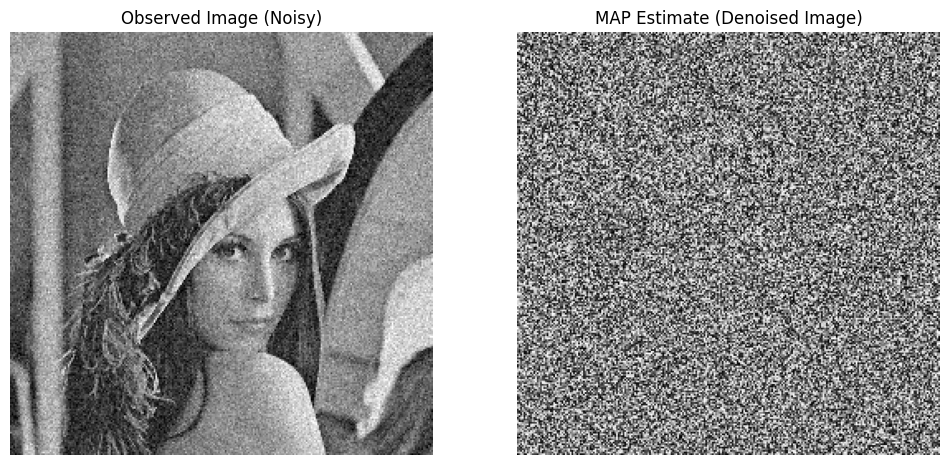

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skimage import io, color

# Define the likelihood function (assuming Gaussian noise)
def likelihood(true_image, observed_image, sigma_n):
    return np.exp(-0.5 * np.sum((observed_image - true_image)*2) / sigma_n*2)

def neg_log_posterior(true_image, observed_image, sigma_n, lambda_):
    # Ensure true_image has at least 2 dimensions
    true_image = np.atleast_2d(true_image)

    neg_log_likelihood = -np.log(likelihood(true_image, observed_image, sigma_n))
    neg_log_prior = -np.log(prior(true_image, lambda_))
    return neg_log_likelihood + neg_log_prior


from scipy.signal import convolve2d

def prior(true_image, lambda_):
    # Ensure true_image has at least 2 dimensions
    true_image = np.atleast_2d(true_image)

    # Reshape true_image to have shape (height, width)
    height, width = true_image.shape
    true_image = true_image.reshape((height, width))

    # Define gradient kernels
    kernel_x = np.array([[1, 0, -1]])
    kernel_y = np.array([[1], [0], [-1]])

    # Compute gradients using convolution
    gradient_x = convolve2d(true_image, kernel_x, mode='same', boundary='symm')
    gradient_y = convolve2d(true_image, kernel_y, mode='same', boundary='symm')

    # Calculate the smoothness penalty
    smoothness_penalty = np.sum(np.sqrt(gradient_x*2 + gradient_y*2))
    
    return np.exp(-lambda_ * smoothness_penalty)


observed_image = noisy  
#observed_image = color.rgb2gray(observed_image)  

# Initial guess for the true image
initial_guess = np.ravel(np.random.rand(*observed_image.shape))
#initial_guess = np.zeros(g.size)

# Regularization parameter
lambda_ = 0.1

# Noise standard deviation
sigma_n = 20  # You need to adjust this according to the characteristics of your noise

# Perform MAP estimation using minimize function
result = minimize(neg_log_posterior, initial_guess, args=(np.ravel(observed_image), sigma_n, lambda_))

# MAP estimate of the true image
map_estimate = result.x

# Reshape the result to the shape of the image
denoised_image = map_estimate.reshape(observed_image.shape)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(observed_image, cmap='gray')
plt.title('Observed Image (Noisy)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('MAP Estimate (Denoised Image)')
plt.axis('off')

plt.show()

C:\Users\vinod\AppData\Local\Temp\ipykernel_11196\2205241052.py:14: RuntimeWarning: divide by zero encountered in log
  neg_log_likelihood = -np.log(likelihood(true_image, observed_image, sigma_n))
C:\Users\vinod\AppData\Local\Temp\ipykernel_11196\2205241052.py:38: RuntimeWarning: invalid value encountered in sqrt
  smoothness_penalty = np.sum(np.sqrt(gradient_x*2 + gradient_y*2))


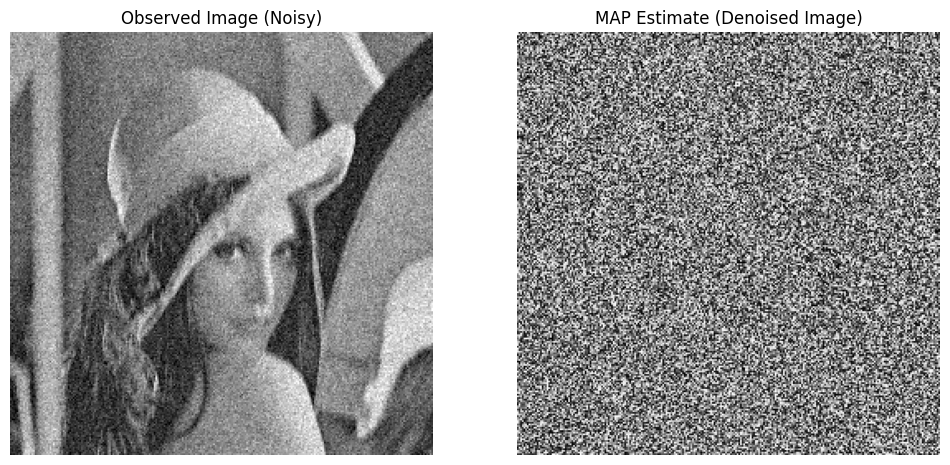

In [6]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skimage import io, color

# Define the likelihood function (assuming Gaussian noise)
def likelihood(true_image, observed_image, sigma_n):
    return np.exp(-0.5 * np.sum((observed_image - true_image)*2) / sigma_n*2)

def neg_log_posterior(true_image, observed_image, sigma_n, lambda_):
    # Ensure true_image has at least 2 dimensions
    true_image = np.atleast_2d(true_image)

    neg_log_likelihood = -np.log(likelihood(true_image, observed_image, sigma_n))
    neg_log_prior = -np.log(prior(true_image, lambda_))
    return neg_log_likelihood + neg_log_prior


from scipy.signal import convolve2d

def prior(true_image, lambda_):
    # Ensure true_image has at least 2 dimensions
    true_image = np.atleast_2d(true_image)

    # Reshape true_image to have shape (height, width)
    height, width = true_image.shape
    true_image = true_image.reshape((height, width))

    # Define gradient kernels
    kernel_x = np.array([[1, 0, -1]])
    kernel_y = np.array([[1], [0], [-1]])

    # Compute gradients using convolution
    gradient_x = convolve2d(true_image, kernel_x, mode='same', boundary='symm')
    gradient_y = convolve2d(true_image, kernel_y, mode='same', boundary='symm')

    # Calculate the smoothness penalty
    smoothness_penalty = np.sum(np.sqrt(gradient_x*2 + gradient_y*2))
    
    return np.exp(-lambda_ * smoothness_penalty)


observed_image = motion_noisy  
#observed_image = color.rgb2gray(observed_image)  

# Initial guess for the true image
initial_guess = np.ravel(np.random.rand(*observed_image.shape))
#initial_guess = np.zeros(g.size)

# Regularization parameter
lambda_ = 0.1

# Noise standard deviation
sigma_n = 20  # You need to adjust this according to the characteristics of your noise

# Perform MAP estimation using minimize function
result = minimize(neg_log_posterior, initial_guess, args=(np.ravel(observed_image), sigma_n, lambda_))

# MAP estimate of the true image
map_estimate = result.x

# Reshape the result to the shape of the image
denoised_image = map_estimate.reshape(observed_image.shape)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(observed_image, cmap='gray')
plt.title('Observed Image (Noisy)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('MAP Estimate (Denoised Image)')
plt.axis('off')

plt.show()

## Deep Network

In [4]:
import numpy 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

In [5]:
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            # Open the image file
            img = Image.open(img_path)
            # Convert the image to numpy array
            img_array = np.array(img)
            # Append the image array to the list
            images.append(img_array)
    return images

# Path to the folder containing images
folder_path = r"D:\Malathi\DL_Project\content\Images"

# Load images from the folder
images = load_images_from_folder(folder_path)


In [17]:
for i, img_array in enumerate(images):
    print(f"Shape of image {i+1}: {img_array.shape}")

Shape of image 1: (500, 375, 3)
Shape of image 2: (375, 500, 3)
Shape of image 3: (400, 500, 3)
Shape of image 4: (410, 500, 3)
Shape of image 5: (461, 500, 3)
Shape of image 6: (333, 500, 3)
Shape of image 7: (333, 500, 3)
Shape of image 8: (334, 500, 3)
Shape of image 9: (375, 500, 3)
Shape of image 10: (375, 500, 3)
Shape of image 11: (429, 500, 3)
Shape of image 12: (357, 500, 3)
Shape of image 13: (500, 333, 3)
Shape of image 14: (487, 500, 3)
Shape of image 15: (334, 500, 3)
Shape of image 16: (303, 500, 3)
Shape of image 17: (375, 500, 3)
Shape of image 18: (375, 500, 3)
Shape of image 19: (281, 500, 3)
Shape of image 20: (198, 500, 3)
Shape of image 21: (333, 500, 3)
Shape of image 22: (500, 333, 3)
Shape of image 23: (333, 500, 3)
Shape of image 24: (292, 500, 3)
Shape of image 25: (375, 500, 3)
Shape of image 26: (375, 500, 3)
Shape of image 27: (500, 375, 3)
Shape of image 28: (215, 500, 3)
Shape of image 29: (375, 500, 3)
Shape of image 30: (500, 375, 3)
Shape of image 31: 

In [6]:
import cv2
import numpy as np

# Define the target size for resizing
target_size = (250, 250)  # Specify the desired width and height

# Create a list to store the resized images
resized_images = []

# Resize each image in the images array
for img in images:
    # Convert the numpy array to a BGR image
    bgr_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Resize the image
    resized_image = cv2.resize(bgr_image, target_size, interpolation=cv2.INTER_AREA)
    
    # Convert the BGR image back to RGB and append it to the resized_images list
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    resized_images.append(resized_image_rgb)

# Convert the resized_images list to a numpy array
resized_images_array = np.array(resized_images)

# Display the shape of the resized images array
print("Resized images shape:", resized_images_array.shape)


Resized images shape: (8091, 250, 250)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(resized_images_array, test_size=2000, random_state=42)

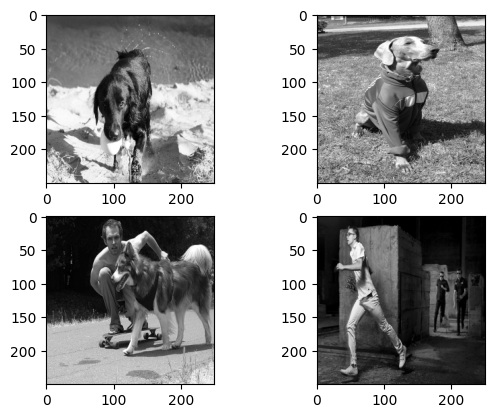

In [20]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [22]:
X_train.shape

(6091, 62500)

In [23]:
X_test.shape

(2000, 62500)

In [9]:
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(x_train_noisy, 0., 1.)
x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)

In [13]:
# create model
model = Sequential()
model.add(Dense(1000, input_dim=num_pixels, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(62500, activation='sigmoid'))

In [14]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# Training model
model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=2, batch_size=10)

Epoch 1/2
610/610 [==============================] - 1647s 3s/step - loss: 0.0574 - val_loss: 0.0493
Epoch 2/2
610/610 [==============================] - 932s 2s/step - loss: 0.0454 - val_loss: 0.0428


In [16]:
# Final evaluation of the model
model.save('my_model.h5')
pred = model.predict(x_test_noisy)

In [18]:
pred.shape

(2000, 62500)

In [19]:
X_test.shape

(2000, 62500)

Test Images


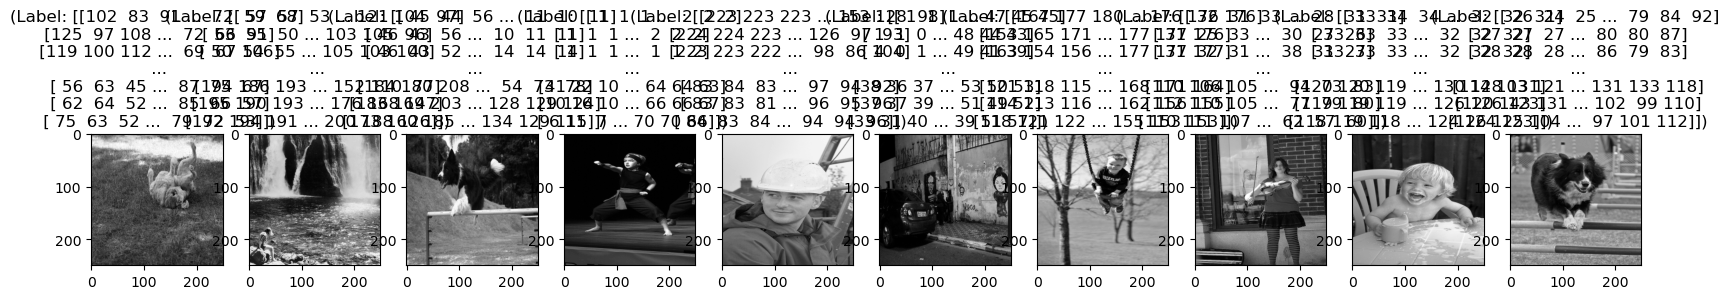

Test Images with Noise


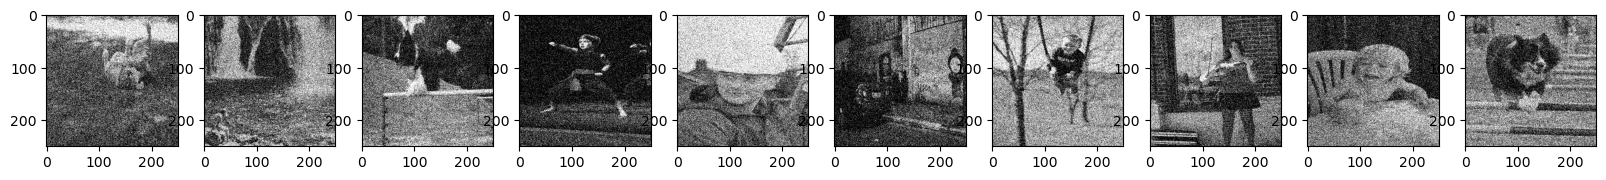

Reconstruction of Noisy Test Images


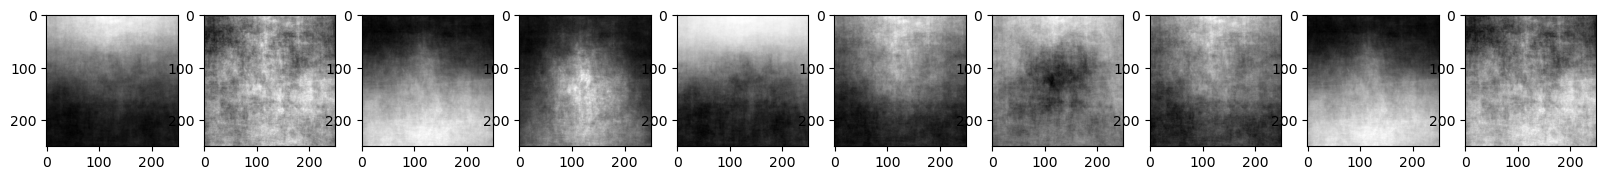

In [26]:
X_test = numpy.reshape(X_test, (2000,250,250)) *255
pred = numpy.reshape(pred, (2000,250,250)) *255
x_test_noisy = numpy.reshape(x_test_noisy, (-1,250,250)) *255
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i,:,:], cmap='gray')
    curr_lbl = X_test[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:], cmap='gray')  
plt.show()

## For MNIST data

In [27]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

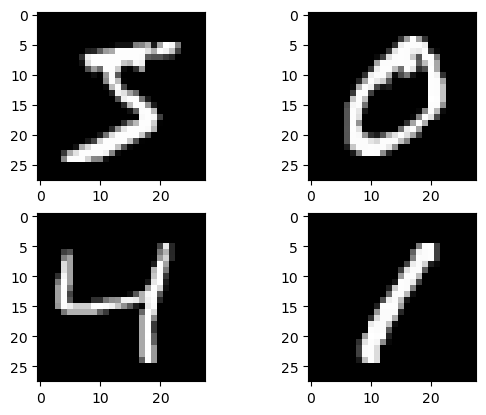

In [28]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [29]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [30]:
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(x_train_noisy, 0., 1.)
x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)

In [31]:
# create model
model = Sequential()
model.add(Dense(500, input_dim=num_pixels, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(784, activation='sigmoid'))

In [32]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Training model
model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=2, batch_size=200)

Epoch 1/2
300/300 [==============================] - 54s 180ms/step - loss: 0.0410 - val_loss: 0.0199
Epoch 2/2
300/300 [==============================] - 62s 207ms/step - loss: 0.0166 - val_loss: 0.0139


In [34]:
# Final evaluation of the model
pred = model.predict(x_test_noisy)

Test Images


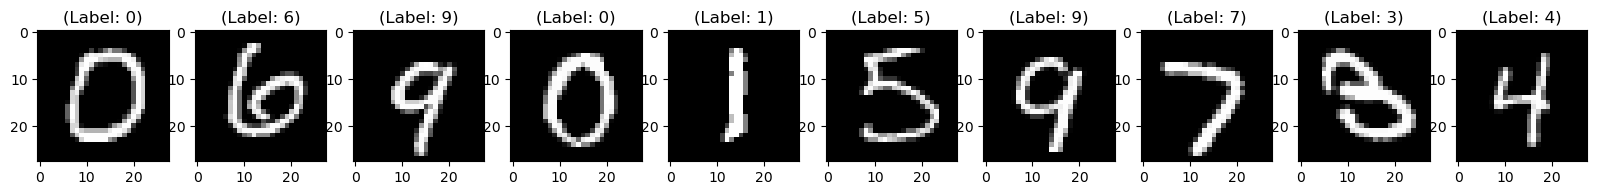

Test Images with Noise


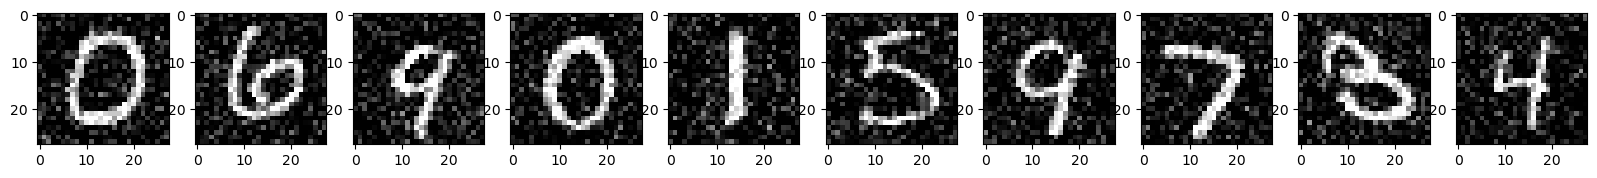

Reconstruction of Noisy Test Images


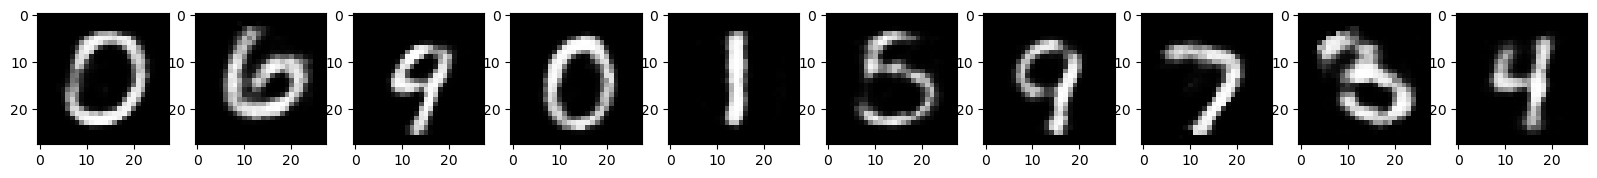

In [35]:
X_test = numpy.reshape(X_test, (10000,28,28)) *255
pred = numpy.reshape(pred, (10000,28,28)) *255
x_test_noisy = numpy.reshape(x_test_noisy, (-1,28,28)) *255
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i,:,:], cmap='gray')
    curr_lbl = y_test[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:], cmap='gray')  
plt.show()